In [1]:
#importing libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import math
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score as f1
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.linear_model import LinearRegression as linreg
from sklearn.metrics import mean_squared_error as rmse

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score ,roc_auc_score as auc, accuracy_score as acc, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve,average_precision_score,average_precision_score as aps,log_loss as ll

from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import FitFailedWarning
import warnings
warnings.simplefilter(action='ignore', category=FitFailedWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
from sklearn.tree import DecisionTreeRegressor as dtr,export_graphviz
from sklearn.model_selection import GridSearchCV as gs, RandomizedSearchCV as rs
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBRegressor as xgbr

In [2]:
r=42 # random state

In [3]:
data = pd.read_csv('spotify_data.csv')

In [4]:
data.dropna(inplace=True) # remove empty rows

In [5]:
data.drop(['URL'], axis=1,inplace=True) # remove url column

In [6]:
data['Date'] = pd.to_datetime(data['Date'], format= '%Y-%m-%d')

In [7]:
date_data = pd.DataFrame({"Year": data['Date'].dt.year,
              "Month": data['Date'].dt.month,
              "Day Of Month": data['Date'].dt.day,
              "Day Of Year": data['Date'].dt.dayofyear,
              "Day Of Week": data['Date'].dt.dayofweek,
              "Day Of Week Name": data['Date'].dt.day_name()
             })

In [8]:
data=data.join(date_data.set_index(data.index), on=data.index).copy() # joining date_data to data and removing original date column
data.drop(['Date'], axis=1,inplace=True)

In [9]:
data.head()

,Position,Track Name,Artist,Streams,Region,Year,Month,Day Of Month,Day Of Year,Day Of Week,Day Of Week Name
0,1,Reggaetón Lento (Bailemos),CNCO,19272,ec,2017,1,1,1,6,Sunday
1,2,Chantaje,Shakira,19270,ec,2017,1,1,1,6,Sunday
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,ec,2017,1,1,1,6,Sunday
3,4,Vente Pa' Ca,Ricky Martin,14954,ec,2017,1,1,1,6,Sunday
4,5,Safari,J Balvin,14269,ec,2017,1,1,1,6,Sunday


In [10]:
data['Region'].unique()

array(['ec', 'fr', 'ar', 'fi', 'no', 'it', 'lt', 'ph', 'tw', 'nz', 'ee',
       'tr', 'us', 'sv', 'cr', 'de', 'cl', 'jp', 'br', 'hn', 'gt', 'ch',
       'hu', 'ca', 'pe', 'be', 'my', 'dk', 'bo', 'pl', 'at', 'pt', 'se',
       'mx', 'pa', 'uy', 'is', 'es', 'cz', 'ie', 'nl', 'sk', 'co', 'sg',
       'id', 'do', 'lu', 'gb', 'global', 'py', 'au', 'lv', 'gr', 'hk'],
      dtype=object)

In [11]:
print(len(data[data['Position']==1]['Track Name'].unique()))
print(len(data[data['Position']==2]['Track Name'].unique()))
print(len(data[data['Position']<=10]['Track Name'].unique()))

256
391
1332


In [12]:
# we make north america and western europe dataframe, including new zealand
# and australia

ameu = np.array(['fr','fi','it','nz','us','de','ch','hu','ca','be','dk','pl','at','pt','se','is','es','cz','ie','nl','sk','lu','gb','au','lv','gr'])

bag_ameu = data.copy()
bag_ameu = bag_ameu.loc[bag_ameu['Region'].isin(ameu)]
bag_ameu.shape

(1651863, 11)

In [30]:
ameu = np.array(['us','gb','au','nz','ca'])

bag_ameu = data.copy()
bag_ameu = bag_ameu.loc[bag_ameu['Region'].isin(ameu)]
bag_ameu.shape

(370943, 11)

#### Bag of words top 10 track names

In [31]:
bag = bag_ameu.copy()
bag = bag[bag['Position']<=10]
bag.shape

(18540, 11)

In [32]:
bag.head()

,Position,Track Name,Artist,Streams,Region,Year,Month,Day Of Month,Day Of Year,Day Of Week,Day Of Week Name
610399,1,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,28957,nz,2017,1,1,1,6,Sunday
610400,2,Starboy,The Weeknd,28259,nz,2017,1,1,1,6,Sunday
610401,3,Closer,The Chainsmokers,26958,nz,2017,1,1,1,6,Sunday
610402,4,24K Magic,Bruno Mars,24563,nz,2017,1,1,1,6,Sunday
610403,5,Say You Won't Let Go,James Arthur,24005,nz,2017,1,1,1,6,Sunday


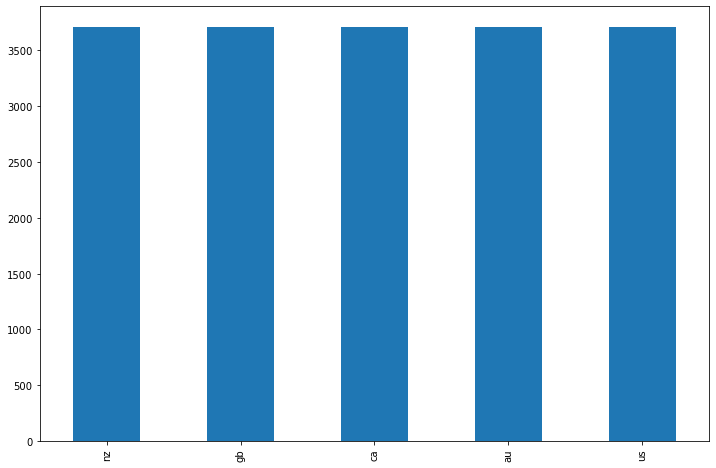

In [33]:
region_counts = bag['Region'].value_counts()
ax = region_counts.plot(kind="bar",figsize=(12,8))

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
top_track_names = np.array(bag['Track Name'])
count = CountVectorizer()
bag_of_words = count.fit_transform(top_track_names)

In [36]:
feature_names = count.get_feature_names()

In [37]:
p1_track_names = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)

In [38]:
p1_track_names

,17,1984,2010,2011,21,222,24k,273,2u,4422,...,yah,yankee,year,yellow,york,you,young,your,zacari,zara
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
bagpos = np.array(bag['Position'])

p1_track_names.insert(loc=0,
          column='Position',
          value=bagpos)
p1_track_names.head(40)

,Position,17,1984,2010,2011,21,222,24k,273,2u,...,yah,yankee,year,yellow,york,you,young,your,zacari,zara
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X = p1_track_names.loc[:, p1_track_names.columns != 'Position'].copy()
Y = p1_track_names['Position'].copy()

In [41]:
print(X.shape)
print(Y.shape)

(18540, 440)
(18540,)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=r,stratify=Y)

In [43]:
print(X_train.shape)
print(X_test.shape)

(14832, 440)
(3708, 440)


Exploratory Analysis is then conducted on the training data

#### PCA

In [44]:
pca = PCA(n_components=200)
X_2d = pca.fit_transform(X_train)

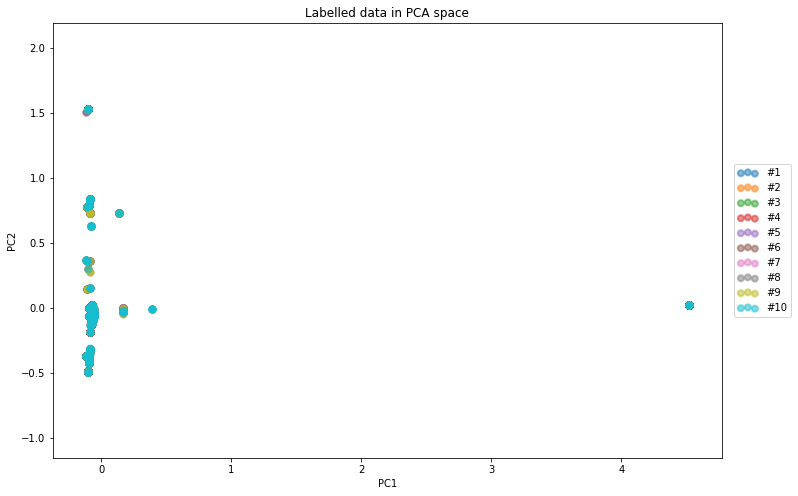

In [45]:
class_categories = ['#1','#2','#3','#4','#5','#6','#7','#8','#9','#10']
class_labels = [1,2,3,4,5,6,7,8,9,10]

sub_labels = [l for l in class_labels if l != 11]
sub_cats = [class_categories[label-1] for label in sub_labels]

plt.figure(figsize=(12,8))
for label, cat in zip(sub_labels, sub_cats):
    plt.scatter(X_2d[y_train == label, 0], X_2d[y_train == label, 1], alpha=.5, lw=2, label=cat)
plt.axis('equal')
plt.legend(loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5])
plt.title('Labelled data in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
top_plot = plt.gca()
plt.show()

In [46]:
xgbmmodel = xgbr(random_state=r,verbosity=0)
xgbmmodel.fit(X_train,y_train)

print('Classification accuracy on training set: {:.3f}'.format(xgbmmodel.score(X_train, y_train)))
print('Classification accuracy on test set: {:.3f}'.format(xgbmmodel.score(X_test, y_test)))

print('MSE on training set: {:.3f}'.format(rmse(y_train,xgbmmodel.predict(X_train),squared=True)))
print('MSE on test set: {:.3f}'.format(rmse(y_test,xgbmmodel.predict(X_test),squared=True)))

Classification accuracy on training set: 0.430
Classification accuracy on test set: 0.423
MSE on training set: 4.701
MSE on test set: 4.758


In [45]:
dt = DecisionTreeClassifier(criterion='entropy',random_state=1000,max_depth=10)
dt.fit(X_train,y_train)

print('Classification accuracy on training set: {:.3f}'.format(dt.score(X_train, y_train)))
print('Classification accuracy on test set: {:.3f}'.format(dt.score(X_test, y_test)))

print('MSE on training set: {:.3f}'.format(rmse(y_train,dt.predict(X_train),squared=True)))
print('MSE on test set: {:.3f}'.format(rmse(y_test,dt.predict(X_test),squared=True)))

Classification accuracy on training set: 0.175
Classification accuracy on test set: 0.174
MSE on training set: 20.188
MSE on test set: 20.346


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)
print('KNN classification (k=1) accuracy on training set: {:.3f}'.format(knn.score(X_train, y_train)))